# Project 2 – Section 2.2
## Up-and-out European Call option
This notebook implements the numerical tasks of Section 2.2:

1. Crude Monte Carlo estimator for the up-and-out European Call.
2. Importance sampling strategy via drift modification (r → r_tilde).
3. PDE-based optimal control importance sampling with barrier.
4. Repetition for a tighter barrier U = 170 with fine PDE discretization.

Parameter values (Section 2.2):
- T = 0.2
- K = 150
- sigma = 0.3
- U = 200 (later also U = 170)
- r = 0.1
- S0 = 100
- EM discretization: M = 1000

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from math import log, sqrt, exp
from scipy.stats import norm 
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.interpolate import RegularGridInterpolator

import plotly.graph_objects as go
from tqdm import tqdm

## Global parameters and payoff

Up-and-out European Call payoff:
$
\psi(\{S(t)\}_{t \in [0,T]}) =
e^{-rT} (S(T) - K)^+ \mathbf{1}_{\{\max_{t \in [0,T]} S(t) \le U\}}.
$

In [18]:
# Parameters for Section 2.2
T_22 = 0.2
K_22 = 150.0
sigma_22 = 0.3
r_22 = 0.1
S0_22 = 100.0
U_22 = 200.0

M_path = 1000
dt_path = T_22 / M_path
sqrt_dt_path = np.sqrt(dt_path)

def payoff_up_and_out_vectored(S_paths, K, r, T, U):
    """
    Vectorized Up-and-out European Call payoff.
    S_paths: array of shape (N, M+1)
    """
    S_T = S_paths[:, -1]
    max_S = np.max(S_paths, axis=1)
    
    not_knocked_out = max_S <= U
    standard_payoffs = np.exp(-r * T) * np.maximum(S_T - K, 0)
    final_payoffs = np.where(not_knocked_out, standard_payoffs, 0.0)
    
    number_knocked_out = np.sum(~not_knocked_out)
    number_over_strike = np.sum(S_T > K)
    
    return final_payoffs, number_knocked_out, number_over_strike


## Euler–Maruyama simulation for GBM paths
SDE:

$
dS(t) = r S(t)\,dt + \sigma S(t)\,dW(t),
$

discretized as:

$
S_{m+1} = S_m + r S_m \Delta t + \sigma S_m \Delta W_m,\quad
\Delta W_m \sim \mathcal{N}(0, \Delta t).
$

In [19]:
def simulate_gbm_em_paths_vectored(N, S0, r, sigma, T, M):
    """
    Vectored simulation of N GBM paths using Euler-Maruyama.
    """
    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    S_paths = np.zeros((N, M + 1))
    S_paths[:, 0] = S0
    
    for m in range(M):
        dW = np.random.normal(0, sqrt_dt, size=N)
        S_paths[:, m + 1] = S_paths[:, m] + (r * S_paths[:, m] * dt) + (sigma * S_paths[:, m] * dW)
    
    return S_paths


## 2.2.1 Crude Monte Carlo

- Simulate N paths of the GBM with EM and M=1000.
- Evaluate the up-and-out payoff on each path.
- Compute the crude Monte Carlo estimator and its standard deviation.

N=10: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=16: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=26: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=42: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=69: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=100: Estimate=0.048027, Std=0.480271, Over Strike=1, Knocked Out=0
N=112: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=183: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=297: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=483: Estimate=0.021392, Std=0.470136, Over Strike=1, Knocked Out=0
N=784: Estimate=0.005541, Std=0.155140, Over Strike=1, Knocked Out=0
N=1000: Estimate=0.017342, Std=0.356399, Over Strike=4, Knocked Out=0
N=1274: Estimate=0.014418, Std=0.514620, Over Strike=1, Knocked Out=0
N=2069: Estimate=0.000000, Std=0.000000, Over Strike=0, Knocked Out=0
N=3359: Estimate=0.006394, Std=0.224

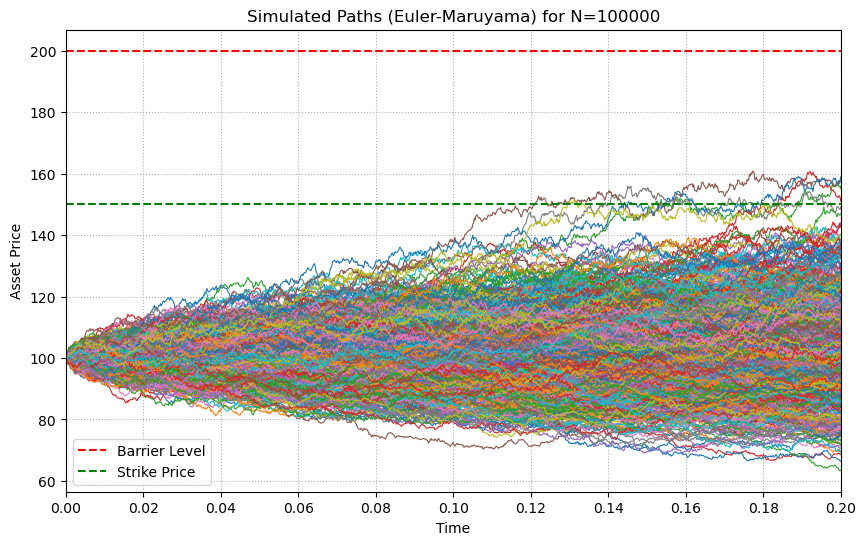

In [20]:
def mc_up_and_out_crude_vectored(N, S0, r, sigma, T, K, U, M):
    """
    Vectored Crude MC estimator for the up-and-out European Call.
    """
    S_paths = simulate_gbm_em_paths_vectored(N, S0, r, sigma, T, M)
    payoffs, number_knocked_out, number_over_strike = payoff_up_and_out_vectored(S_paths, K, r, T, U)
    
    est = np.mean(payoffs)
    std = np.std(payoffs, ddof=1)
    
    return est, std, S_paths, payoffs, number_knocked_out, number_over_strike


n_range = np.logspace(1, 5, num=20, dtype=int)
n_range = np.append(n_range, [100,1000,10000])
n_range = sorted(np.unique(n_range))
mc_results_22 = []

for N in n_range:
    est, std, S_paths, payoffs, number_knocked_out, number_over_strike = mc_up_and_out_crude_vectored(N, S0_22, r_22, sigma_22, T_22, K_22, U_22, M_path)
    print(f"N={N}: Estimate={est:.6f}, Std={std:.6f}, Over Strike={number_over_strike}, Knocked Out={number_knocked_out}")
    mc_results_22.append((N, est, std, S_paths, payoffs, number_knocked_out, number_over_strike))

n_vals = np.array([res[0] for res in mc_results_22])
estimates = np.array([res[1] for res in mc_results_22])
stds = np.array([res[2] for res in mc_results_22])
lower_errs = estimates - 1.96 * stds / np.sqrt(n_vals)
upper_errs = estimates + 1.96 * stds / np.sqrt(n_vals)
res_knocked = np.array([res[5] for res in mc_results_22])
res_strike = np.array([res[6] for res in mc_results_22])


labels=[f"{T_22/10*i:.2f}" for i in range(11)]
plt.figure(figsize=(10,6))
for i in range(min(N,1000)):
    plt.plot(mc_results_22[-1][3][i], lw=0.8)
plt.axhline(U_22, color='red', linestyle='--', label='Barrier Level')
plt.axhline(K_22, color='green', linestyle='--', label='Strike Price')
plt.title(f"Simulated Paths (Euler-Maruyama) for N={mc_results_22[-1][0]}")
plt.xlabel("Time")
plt.ylabel("Asset Price")
plt.xlim(0, M_path)
plt.xticks(np.linspace(0, M_path, 11), labels=[f"{T_22/10*i:.2f}" for i in range(11)])
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.8)
plt.show()

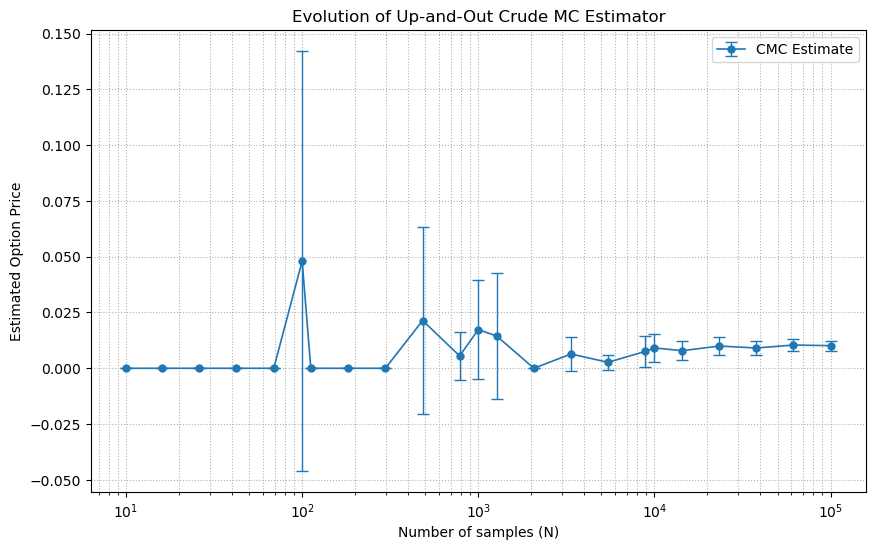

Number of Knocked Out Paths (N=100000): 0
Number of Paths Over Strike (N=100000): 149


In [21]:
yerr = np.array([estimates - lower_errs, upper_errs - estimates])
plt.figure(figsize=(10, 6))
plt.errorbar(
    n_vals,
    estimates,
    yerr=yerr,
    fmt='o-',
    markersize=5,
    linewidth=1.2,
    capsize=4,
    capthick=1.0,
    elinewidth=1.0,
    label='CMC Estimate'
)
plt.xscale('log')
plt.xlabel('Number of samples (N)')
plt.ylabel('Estimated Option Price')
plt.title('Evolution of Up-and-Out Crude MC Estimator')
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.8)
plt.show()

print(f"Number of Knocked Out Paths (N={n_vals[-1]}): {res_knocked[-1]}")
print(f"Number of Paths Over Strike (N={n_vals[-1]}): {res_strike[-1]}")

## 2.2.2 Importance Sampling via drift modification

We simulate the GBM under drift $\tilde{r}$, track the Brownian increments $\Delta W$,
and reweight with the pathwise Girsanov factor:

$
w = \exp\left(-\theta \tilde W_T + \frac{1}{2}\theta^2 T\right),
\qquad \theta = \frac{r - \tilde{r}}{\sigma}.
$

Estimator:
$
\hat{Z}_{\text{IS}} =
\frac{1}{N}\sum_{i=1}^N \psi(\text{path}^{(i)}) w^{(i)}.
$

### Grid-based adaptive selection of $\tilde{r}$

For a given sample size N_base:
- Loop over $\tilde{r}$ in a grid.
- For each $\tilde{r}$, estimate the IS variance.
- Select the $\tilde{r}$ with minimal estimated variance.

Then, with this $\tilde{r}^*$, we can increase N until a desired CI half-width is achieved.

In [22]:
def simulate_fixed_rtilde_is(S0, K, r, sigma, T, U, M, N, r_tilde, random_seed=123):
    """
    Simulates paths with a fixed r_tilde to observe the effect on 
    Strike hits and Barrier knock-outs.
    Based on the Algorithm 6.7 in the lecture notes.
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    dt = T / M
    sqrt_dt = np.sqrt(dt)
    
    W_T_paths = np.zeros(N)
    S_paths = np.ones((N, M + 1)) * S0
    
    for m in range(M):
        dW = np.random.normal(0, sqrt_dt, size=N)
        S_paths[:, m+1] = S_paths[:, m] + (r_tilde * S_paths[:, m] * dt) + \
                          (sigma * S_paths[:, m] * dW)
        W_T_paths += dW

    payoffs, num_knocked, num_strike = payoff_up_and_out_vectored(S_paths, K, r, T, U)
    
    theta = (r - r_tilde) / sigma
    weights = np.exp(-theta * W_T_paths - 0.5 * (theta**2) * T)
    
    weighted_payoffs = payoffs * weights
    estimate = np.mean(weighted_payoffs)
    std_err = np.std(weighted_payoffs, ddof=1) / np.sqrt(N)
    
    return {
        "estimate": estimate,
        "std_err": std_err,
        "num_strike": num_strike,
        "num_knocked": num_knocked,
        "S_paths": S_paths
    }

r_values = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 4.0]
N_samples = 100_000

all_res = []
for rt in r_values:
    res = simulate_fixed_rtilde_is(S0_22, K_22, r_22, sigma_22, T_22, U_22, M_path, N_samples, rt)
    all_res.append(res)
    print(f"r_tilde: {rt:.2f} | Strike Hits: {res['num_strike']} | Knock-outs: {res['num_knocked']} | Est: {res['estimate']:.6f} | StdErr: {res['std_err']:.6f}")


r_tilde: 0.00 | Strike Hits: 90 | Knock-outs: 0 | Est: 0.003635 | StdErr: 0.000521
r_tilde: 0.50 | Strike Hits: 920 | Knock-outs: 3 | Est: 0.310408 | StdErr: 0.017679
r_tilde: 1.00 | Strike Hits: 5485 | Knock-outs: 16 | Est: 5.290077 | StdErr: 0.163465
r_tilde: 1.50 | Strike Hits: 19701 | Knock-outs: 165 | Est: 16.198172 | StdErr: 0.321840
r_tilde: 2.00 | Strike Hits: 45827 | Knock-outs: 1512 | Est: 8.474218 | StdErr: 0.114879
r_tilde: 2.50 | Strike Hits: 73898 | Knock-outs: 7775 | Est: 0.619988 | StdErr: 0.005974
r_tilde: 3.00 | Strike Hits: 91647 | Knock-outs: 24942 | Est: 0.005944 | StdErr: 0.000048
r_tilde: 4.00 | Strike Hits: 99807 | Knock-outs: 79045 | Est: 0.000000 | StdErr: 0.000000


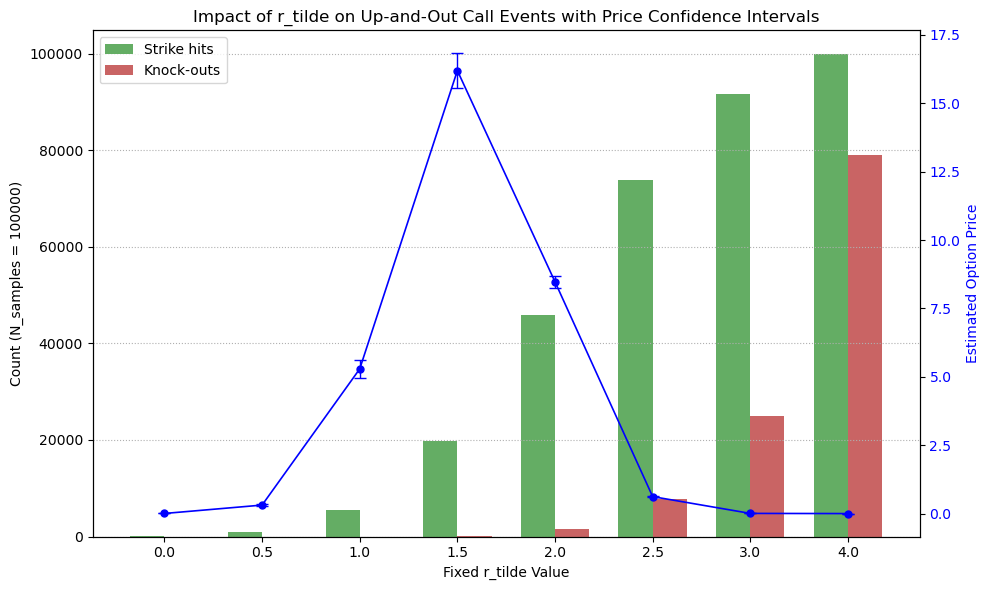

In [23]:
strike_hits = [res['num_strike'] for res in all_res]
knock_outs = [res['num_knocked'] for res in all_res]
estimates = [res['estimate'] for res in all_res]

errors = [1.96 * res['std_err'] for res in all_res]
r_labels = [f"{rt:.1f}" for rt in r_values]

x = np.arange(len(r_labels))
width = 0.35
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(x - width/2, strike_hits, width, label='Strike hits', color='forestgreen', alpha=0.7)
ax1.bar(x + width/2, knock_outs, width, label='Knock-outs', color='firebrick', alpha=0.7)
ax1.set_xlabel('Fixed r_tilde Value')
ax1.set_ylabel(f'Count (N_samples = {N_samples})')
ax1.set_title('Impact of r_tilde on Up-and-Out Call Events with Price Confidence Intervals')
ax1.set_xticks(x)
ax1.set_xticklabels(r_labels)
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle=':', linewidth=0.8)

ax2 = ax1.twinx()
ax2.errorbar(x, estimates, color='blue', yerr=errors, fmt='o-', markersize=5, linewidth=1.2, capsize=4, capthick=1.0, elinewidth=1.0, label='Price Estimate (95% CI)')
ax2.set_ylabel('Estimated Option Price', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
fig.tight_layout()
plt.show()

We observe that, depending on $\tilde{r}$, the paths are steered towards the strike price, and ultimately the barrier. There is a tradeoff between a low $\tilde{r}$ where almost no paths result in a positive payoff, and a high $\tilde{r}$ where most of the paths hit the barrier, giving a 0 payoff.

In [24]:
def adaptive_is_up_and_out_rtilde(
    S0, K, r, sigma, T, U, M,
    tol=1e-3, alpha=0.05,
    N_bar=1000, gamma=2.0,
    r_min=0.1, r_max=5.0,
    n_grid=50,
    n_refine=201,
    refine_half_width=0.25,
    max_iter=20,
    random_seed=123
):
    """
    Adaptive IS for up-and-out European Call option using r_tilde optimization, 
    following Algorithm 6.4/6.7.

    The minimization is performed via a two-stage grid search, 
    first minimizing the empirical J(theta) over a course grid, then refining around the best candidate.  
    """
    if random_seed is not None:
        np.random.seed(random_seed)

    c = norm.ppf(1 - alpha / 2.0)
    dt = T / M
    
    # Initialize 
    N = int(N_bar / gamma)
    r_tilde = r_min
    sigma_hat = np.inf

    history = {"r_tilde": [], "N": [], "Z_hat": [], "sigma_hat": []}

    for it in range(max_iter):
        halfwidth = c * sigma_hat / np.sqrt(N)
        print(f"Iteration {it+1}: N={N}, r_tilde={r_tilde:.4f}, sigma_hat={sigma_hat:.6f}")
        print(f"  Current tolerance check (half-width vs tol): {halfwidth:.6f} <= {tol:.6f}")
        
        if halfwidth <= tol: 
            print(f"\n** Tolerance achieved at iteration {it} **")
            break

        N = int(gamma * N)
        
        # We track the sum of dW to compute the Girsanov likelihood ratio
        W_T_paths = np.zeros(N)
        S_paths = np.ones((N, M + 1)) * S0
        sqrt_dt = np.sqrt(dt)
        
        for m in range(M):
            dW = np.random.normal(0, sqrt_dt, size=N)
            S_paths[:, m+1] = S_paths[:, m] + (r_tilde * S_paths[:, m] * dt) + (sigma * S_paths[:, m] * dW)
            W_T_paths += dW

        payoffs, num_knocked, num_strike = payoff_up_and_out_vectored(S_paths, K, r, T, U)
        print(f"  Strike={num_strike}, Knocked={num_knocked}\n")
        
        # Likelihood ratio: L = exp(-theta * W_T - 0.5 * theta^2 * T)
        theta_curr = (r - r_tilde) / sigma
        w_curr = np.exp(-theta_curr * W_T_paths - 0.5 * (theta_curr**2) * T)
        weighted = payoffs * w_curr

        Z_hat = np.mean(weighted)
        sigma_hat = np.std(weighted, ddof=1)
        
        # Objective: minimize E[ (Payoff * L)^2 ]
        r_grid_coarse = np.linspace(r_min, r_max, n_grid)
        J_coarse = []
        
        for r_cand in r_grid_coarse:
            theta_cand = (r - r_cand) / sigma
            L_cand = np.exp(-theta_cand * W_T_paths - 0.5 * (theta_cand**2) * T)
            J_coarse.append(np.mean((payoffs * L_cand)**2))
        
        best_coarse = r_grid_coarse[np.argmin(J_coarse)]
        
        
        # Refinement
        lo = max(r_min, best_coarse - refine_half_width)
        hi = min(r_max, best_coarse + refine_half_width)
        r_grid_fine = np.linspace(lo, hi, n_refine)
        J_fine = [np.mean((payoffs * np.exp(-((r - rc)/sigma) * W_T_paths - 0.5*((r - rc)/sigma)**2 * T))**2) 
                    for rc in r_grid_fine]
            
        r_tilde = float(r_grid_fine[np.argmin(J_fine)])

        # Update History
        history["r_tilde"].append(r_tilde)
        history["N"].append(N)
        history["Z_hat"].append(Z_hat)
        history["sigma_hat"].append(sigma_hat)

    return {**history, "S_paths": S_paths, "final_strike": num_strike, "final_knocked": num_knocked}

In [25]:
adaptive_results_dict = adaptive_is_up_and_out_rtilde(
    S0=S0_22, K=K_22, r=r_22, sigma=sigma_22, T=T_22, U=U_22, M=M_path,
    r_min =1.5, r_max=2.5,
    tol=5e-2,
    alpha=0.05,
    N_bar=100_001,
    gamma=1.5
)

Iteration 1: N=66667, r_tilde=1.5000, sigma_hat=inf
  Current tolerance check (half-width vs tol): inf <= 0.050000
  Strike=19701, Knocked=165

Iteration 2: N=100000, r_tilde=2.5000, sigma_hat=101.774802
  Current tolerance check (half-width vs tol): 0.630795 <= 0.050000
  Strike=110675, Knocked=11606

Iteration 3: N=150000, r_tilde=2.5000, sigma_hat=1.893277
  Current tolerance check (half-width vs tol): 0.009581 <= 0.050000

** Tolerance achieved at iteration 2 **


Final IS Estimate: 0.621824
Final Std Error: 1.893277
Final r_tilde: 2.500000
Paths hitting Strike: 110675
Paths hitting Barrier: 11606


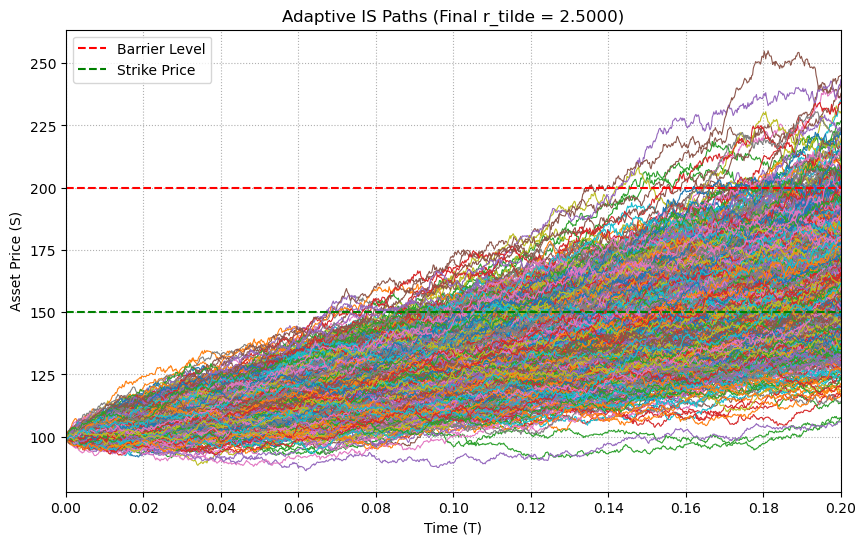

In [26]:
final_price = adaptive_results_dict["Z_hat"][-1]
final_std = adaptive_results_dict["sigma_hat"][-1]
final_paths = adaptive_results_dict["S_paths"]
n_knocked = adaptive_results_dict["final_knocked"]
n_strike = adaptive_results_dict["final_strike"]

print(f"Final IS Estimate: {final_price:.6f}")
print(f"Final Std Error: {final_std:.6f}")
print(f"Final r_tilde: {adaptive_results_dict['r_tilde'][-1]:.6f}")
print(f"Paths hitting Strike: {n_strike}")
print(f"Paths hitting Barrier: {n_knocked}")


labels = [f"{T_22/10*i:.2f}" for i in range(11)]
plt.figure(figsize=(10,6))
for i in range(min(len(final_paths), 1000)):
    plt.plot(final_paths[i], lw=0.8)
plt.axhline(U_22, color='red', linestyle='--', label='Barrier Level')
plt.axhline(K_22, color='green', linestyle='--', label='Strike Price')
plt.title(f"Adaptive IS Paths (Final r_tilde = {adaptive_results_dict['r_tilde'][-1]:.4f})")
plt.xlabel("Time (T)")
plt.ylabel("Asset Price (S)")
plt.xlim(0, M_path)
plt.xticks(np.linspace(0, M_path, 11), labels=labels)
plt.legend()
plt.grid(True, which='both', linestyle=':', linewidth=0.8)
plt.show()


Implementing an adaptive $\tilde{r}$ effectively steers the paths towards the strike price and the barrier, but we observe that a constant $\tilde{r}$ is not the optimal solution since, no matter the $[r_{min}, r_{max}]$ interval chosen for the adaptive algorithm, the optimal $\tilde{r}$ always ends up on an extremity.

For a low $\tilde{r}$, the payoffs are almost always 0 and the variance is very low, while for a high $\tilde{r}$, most of the paths are knocked out ang give a 0 payoff, resulting also in a very low variance.

## 2.2.3 PDE with barrier and optimal control $\zeta^*$
We solve the PDE

$\frac{\partial v}{\partial t} + rs \frac{dv}{ds} + \frac{1}{2}\sigma^2 s^2 \frac{\partial^2 v}{\partial s^2}$,

with:
- Final condition: $v(T, s) = (s - K)^+ e^{-rT}$.
- Spatial domain:
    - $S_\text{min}$ as in the Section 2.1 guideline: $S_\text{min} = S_0 \exp\{ (r- 0.5\sigma^2)T - 6 \sigma \sqrt{T} \}$,
    - $S_\text{max} = U$.
- Boundary conditions: $v(t, S_\text{min}) = 0, \quad v(t, S_\text{max}) = \varepsilon, \quad \varepsilon = 0.1$.

Again, we use implicit Euler in time and centered finite differences in space.



In [5]:
def solve_kbe_pde_barrier(S0, K, r, sigma, T, U,
                          P, M_tilde,
                          epsilon_bc=0.1,
                          Smin_sigma_mult=6.0):
    """
    Solves the KBE (Kolmogorov Backward Equation) on s in [Smin, Smax], where Smax is the barrier level U as requested

    Boundaries:
    v(t, Smin) = 0
    v(t, U) = epsilon_bc
    Terminal condition:
    v(T, s) = exp(-r*T) * max(s - K, 0)
    """
    
    # Domain with Smin lognormal spread, Smax at U
    Smin = S0 * np.exp((r - 0.5 * sigma**2) * T - Smin_sigma_mult * sigma * np.sqrt(T)) # not sure sigma mult
    Smax = U
    
    ds = (Smax - Smin) / P
    dt = T / M_tilde
    
    s_vals = Smin + ds * np.arange(P + 1)
    t_vals = dt * np.arange(M_tilde + 1)
    
    # rows for time, columns for space
    V = np.zeros((M_tilde + 1, P + 1), dtype=float)
    
    # Final payoff at maturity
    V[-1, :] = np.exp(-r*T) * np.maximum(s_vals-K, 0.0)
    
    # Boundary conditions wrt time
    V[:, 0] = 0.0
    V[:, -1] = epsilon_bc  # epsilon value near barrier as requested
    
    s_inner = s_vals[1: -1] 
    N = len(s_inner)
    
    # Coefficients for tridiagonal matrix
    # Ssecond-order spatial derivatives + first-order drift as in notes
    lower_diag = (dt*r*s_inner) /(2 * ds) - (dt*sigma**2 * s_inner**2)/(2*ds**2)
    center_diag = 1.0 + (dt * sigma**2*s_inner**2)/(ds**2)
    upper_diag = -(dt*r*s_inner)/(2*ds) - (dt*sigma**2 * s_inner**2)/(2*ds**2)
    
    A = diags( diagonals=[lower_diag[1:], center_diag, upper_diag[:-1]], offsets=[-1, 0, 1], format='csc')
    
    # Backward wrt time
    for m in range(M_tilde-1, -1, -1):
        rhs = V[m+1, 1:-1].copy()
        # boundaryon RHS
        rhs[-1] -= upper_diag[-1]*V[m, -1]
        # Solve A * V^m = V^{m+1}
        V[m, 1:-1] = spsolve(A, rhs)
        V[m, 0] = 0.0
        V[m, -1] = epsilon_bc
        
        
    return t_vals, s_vals, V

### Computing $\zeta^*(t,s)$ and interpolation

We compute:

$
\zeta^*(t,s) = \sigma s \frac{\partial}{\partial s} \log v(t,s),
$

with centered finite differences in $s$, boundary prolongation at $S_\text{min}$,
and zero control at t = T.

In [6]:
def make_zeta_star_interpolator(t_vals, s_vals, V, sigma):
    """
    Construct zeta_star(t, s) = sigma * s * (v_s / v)
    """
    
    # Steps
    delta_t = t_vals[1]-t_vals[0]
    delta_s = s_vals[1]-s_vals[0]

    num_s = len(s_vals)
    num_t = len(t_vals)

    # Init derivative
    dV_ds = np.zeros_like(V)
    
    for j in range(1, num_s - 1):
        dV_ds[:, j] = (V[:, j+1] - V[:, j-1])/(2.0*delta_s)
        
    # Use forward and backward diff at the boundaries
    dV_ds[:, 0] = (V[:, 1] - V[:, 0]) / delta_s
    dV_ds[:, -1] = (V[:, -1] - V[:, -2]) / delta_s
    
    V_adjusted = np.maximum(V, 1e-12)
    
    # zeta values
    zeta_vals = sigma * s_vals[None, :] * (dV_ds/V_adjusted)
    
    # Boundaries
    zeta_vals[-1, :] = 0.0  # final time to zero
    zeta_vals[:, 0] = zeta_vals[:, 1]
    
    # Create interpolator
    zeta_fn = RegularGridInterpolator(
        (t_vals, s_vals),
        zeta_vals,
        bounds_error=False,
        fill_value=None) #problem with nan in the convergence part
    
    return zeta_vals, zeta_fn

In [7]:
def simulate_controlled_gbm_is_up_and_out(
    S0, K, r, sigma, T, U, M, N, zeta_eval,
    random_seed=123):
    """
    Simulate controlled GBM.
    Payoff:
        exp(-rT) * max(S_T - K, 0) * 1{ max S_t <= U }
    Weights:
        log w = -sum zeta * dW - 0.5 * sum zeta^2 * dt
    Returns: full path data for track
    """
    
    rng = np.random.default_rng(random_seed)

    dt = T/M
    sqrt_dt = np.sqrt(dt)

    # paths
    S_paths = np.zeros((N, M+1), dtype=float)
    S_paths[:, 0] = S0

    # Track the max value per path for barrier crossing
    running_max = np.full(N, S0)

    # initialize
    log_w = np.zeros(N)

    for m in range(M):
        t_m = m * dt
        S_curr = S_paths[:, m]

        time_input = np.full(N, t_m)
        zeta_vals = zeta_eval(np.column_stack((time_input, S_curr)))

        dW = rng.normal(0.0, 1.0, N) * sqrt_dt
        #Euler
        drift_term = r * S_curr + sigma * S_curr * zeta_vals
        noise_term = sigma * S_curr * dW
        S_next = S_curr + drift_term * dt + noise_term

        S_paths[:, m + 1] = S_next

        # store max value
        running_max = np.maximum(running_max, S_next)

        log_w += -zeta_vals*dW - 0.5*(zeta_vals**2)*dt

    # finql value
    S_T = S_paths[:, -1]

    # from log to normal
    weights = np.exp(log_w)
    in_the_money = np.maximum(S_T - K, 0.0)
    knocked_in = (running_max <= U)
    discounted = np.exp(-r * T)
    payoffs = in_the_money * knocked_in * discounted
    weighted_payoffs = weights * payoffs

    # stats
    Z_hat = weighted_payoffs.mean() # price
    sigma_hat = weighted_payoffs.std(ddof=1)
    std_err = sigma_hat / np.sqrt(N)

    stats = {"Z_hat": Z_hat, "sigma_hat": sigma_hat, "std_err": std_err}
    

    return stats, S_paths

### Solving PDE and computing $\zeta^*$ for U = 200

Use a moderate grid, e.g. $P = 200$, $\tilde{M} = 200$, and then:
- plot $\zeta^*(t,s)$ on a restricted region for inspection,
- simulate controlled paths with this $\zeta^*$.

In [8]:
# Parameters for 2.2.3
S0_23 = 100.0
K_23  = 150.0
r_23  = 0.10
sigma_23 = 0.30
T_23  = 0.20

U_23  = 200.0 #barrier

# PDE Parameters (moderate grid)
P_pde = 200
Mtilde_pde = 200

# Calculus
t_grid_u23, s_grid_u23, V_u23 = solve_kbe_pde_barrier(
    S0=S0_23, K=K_23, r=r_23, sigma=sigma_23, T=T_23, U=U_23,
    P=P_pde, M_tilde=Mtilde_pde,
    epsilon_bc=0.1)

zeta_u23, zeta_eval_u23 = make_zeta_star_interpolator(t_grid_u23, s_grid_u23, V_u23, sigma_23)

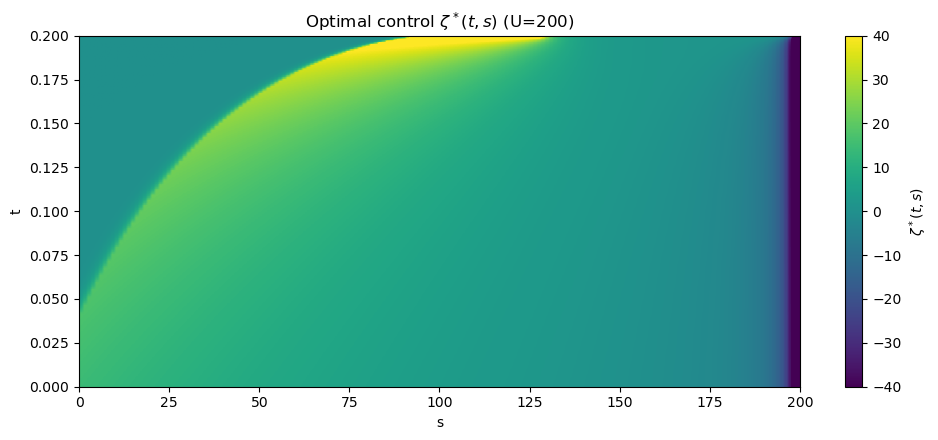

In [9]:
# Plot zeta*
t_max = 0.2
S_low = 60
S_up = U_23
mask_t = (t_grid_u23<=t_max)
mask_s = (s_grid_u23>=S_low) & (s_grid_u23<=S_up)

T_plot = t_grid_u23[mask_t]
S_plot = s_grid_u23[mask_s]
Z_plot = zeta_u23[np.ix_(mask_t, mask_s)]

plt.figure(figsize=(10, 4.5))
plt.imshow(
    Z_plot,
    aspect="auto",
    origin="lower",
    extent=[0, 200, 0, 0.2],
    vmin=-40, vmax=40)

plt.colorbar(label=r'$\zeta^*(t,s)$')
plt.xlabel("s")
plt.ylabel("t")
plt.title(r'Optimal control $\zeta^*(t,s)$ (U=200)')
plt.tight_layout()
plt.show()

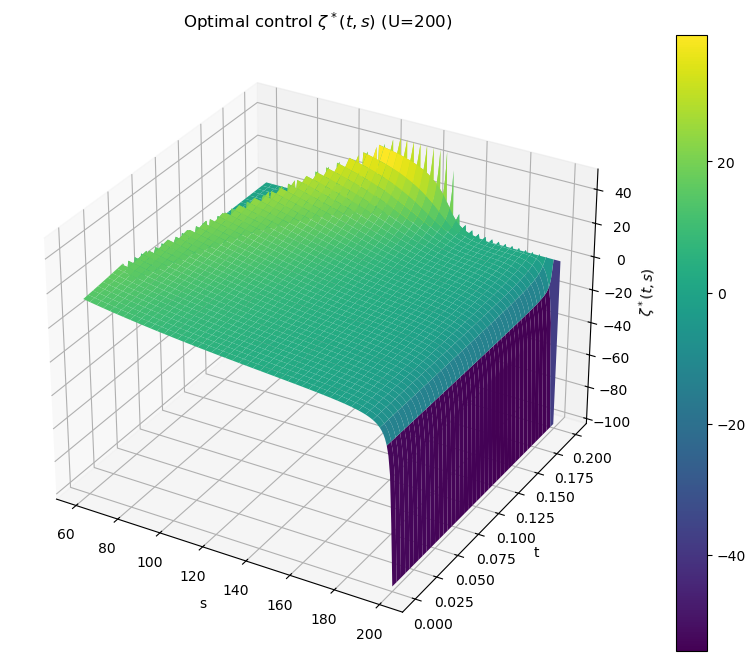

In [10]:
# 3d
ZZ = np.clip(Z_plot, -100.0, 100.0) # fix space as it goes to - inf
TT, SS = np.meshgrid(T_plot, S_plot, indexing="ij")

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(SS, TT, ZZ, cmap="viridis")

ax.set_xlabel("s")
ax.set_ylabel("t")
ax.set_zlabel(r"$\zeta^*(t,s)$")
ax.set_title(r"Optimal control $\zeta^*(t,s)$ (U=200)")

fig.colorbar(surf)
plt.show()

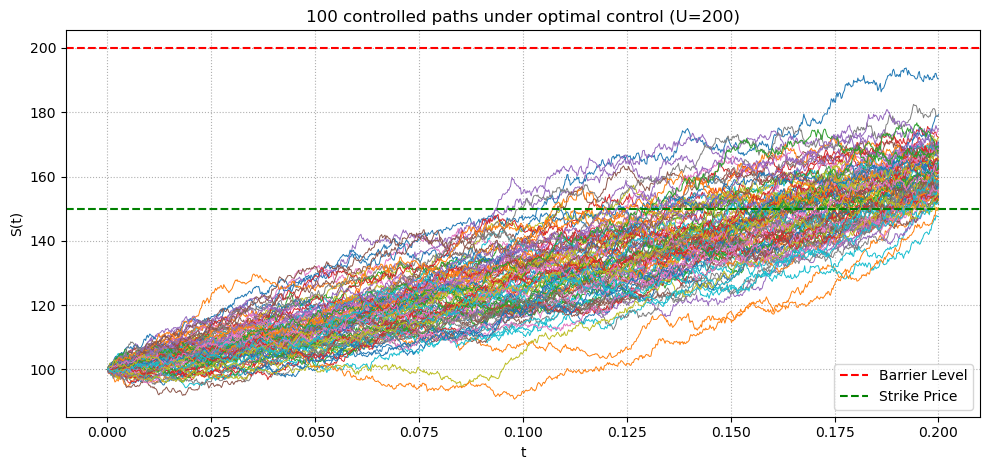

In [11]:
# 100 controlled paths
stats_100, paths_100 = simulate_controlled_gbm_is_up_and_out(
    S0=S0_23, K=K_23, r=r_23, sigma=sigma_23, T=T_23, U=U_23,
    M=1000, N=100, # sample of 100 with M=1000
    zeta_eval=zeta_eval_u23)

t_path = np.linspace(0.0, T_23, 1001)

plt.figure(figsize=(10, 4.8))
for i in range(paths_100.shape[0]):
    plt.plot(t_path, paths_100[i], linewidth=0.7)

plt.axhline(U_23, color='red', linestyle='--', label='Barrier Level')
plt.axhline(K_23, color='green', linestyle='--', label='Strike Price')
plt.xlabel("t")
plt.ylabel("S(t)")
plt.title("100 controlled paths under optimal control (U=200)")
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()

N=10 , Z_hat=0.010153 , StdErr=0.001064 , sigma=0.003366 , 95% CI Lower=0.008067 , 95% CI Upper=0.012239 , CI len=0.004172 , Over Strike=10 , Barrier Hits=0
N=16 , Z_hat=0.010456 , StdErr=0.000272 , sigma=0.001088 , 95% CI Lower=0.009923 , 95% CI Upper=0.010989 , CI len=0.001067 , Over Strike=16 , Barrier Hits=0
N=26 , Z_hat=0.010109 , StdErr=0.000397 , sigma=0.002026 , 95% CI Lower=0.009330 , 95% CI Upper=0.010888 , CI len=0.001558 , Over Strike=26 , Barrier Hits=0
N=42 , Z_hat=0.009315 , StdErr=0.000407 , sigma=0.002641 , 95% CI Lower=0.008516 , 95% CI Upper=0.010113 , CI len=0.001597 , Over Strike=40 , Barrier Hits=0
N=69 , Z_hat=0.009414 , StdErr=0.000312 , sigma=0.002590 , 95% CI Lower=0.008803 , 95% CI Upper=0.010025 , CI len=0.001222 , Over Strike=66 , Barrier Hits=0
N=100 , Z_hat=0.009633 , StdErr=0.000195 , sigma=0.001946 , 95% CI Lower=0.009252 , 95% CI Upper=0.010015 , CI len=0.000763 , Over Strike=99 , Barrier Hits=0
N=112 , Z_hat=0.009218 , StdErr=0.000248 , sigma=0.002622

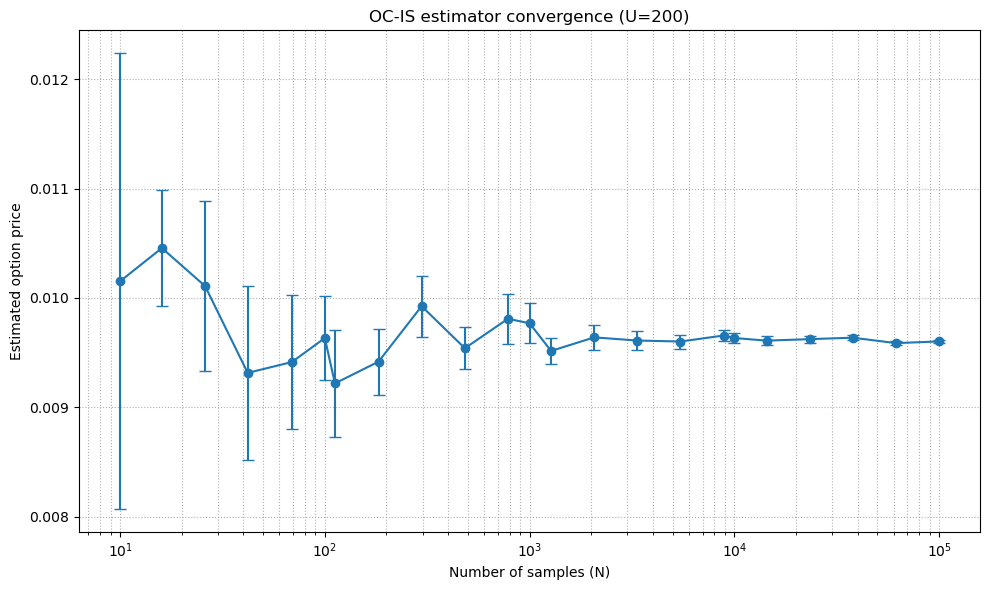

In [19]:
# OC-IS price for several samples
# N_list = [10, 100, 1_000, 10_000, 100_000]
oc_estimates = []
oc_stderr = []

# to have same sample points as before
n_range = np.logspace(1, 5, num=20, dtype=int)
n_range = np.append(n_range, [100,1000,10000])
n_range = sorted(np.unique(n_range))
N_list = n_range

for N in N_list:
    statsN, paths = simulate_controlled_gbm_is_up_and_out(
        S0=S0_23, K=K_23, r=r_23, sigma=sigma_23, T=T_23, U=U_23,
        M=1000, N=N, zeta_eval=zeta_eval_u23)
    
    Z_hat = statsN["Z_hat"]
    stderr = statsN["std_err"]
    sigma_hat = stderr * np.sqrt(N)
    # CI at 95%
    ci_low = Z_hat - 1.96*stderr
    ci_up = Z_hat + 1.96*stderr
    ci_len = ci_up-ci_low
    
    # Counting over strike qnd hitting barrier
    S_T = paths[:, -1]
    S_max = paths.max(axis=1)
    overK = int( np.sum(S_T>K_23) ) #nb over the strike
    KO = int( np.sum(S_max>U_23) ) #nb hitting the barrier

    # Print the values
    print(
        f"N={N} , "
        f"Z_hat={Z_hat:.6f} , "
        f"StdErr={stderr:.6f} , "
        f"sigma={sigma_hat:.6f} , "
        f"95% CI Lower={ci_low:.6f} , "
        f"95% CI Upper={ci_up:.6f} , "
        f"CI len={ci_len:.6f} , "
        f"Over Strike={overK} , "
        f"Barrier Hits={KO}")

    # Storing
    oc_estimates.append(Z_hat)
    oc_stderr.append(stderr)

# Shaping
oc_estimates = np.array(oc_estimates)
oc_stderr   = np.array(oc_stderr)
N_arr = np.array(N_list)

# 95% CI
oc_lower = oc_estimates - 1.96*oc_stderr
oc_upper = oc_estimates + 1.96*oc_stderr
yerr = np.vstack([oc_estimates-oc_lower, oc_upper-oc_estimates])

# Plot convergence curve
plt.figure(figsize=(10, 6))
plt.errorbar(N_arr, oc_estimates, yerr=yerr, fmt="o-", capsize=4)
plt.xscale("log")
plt.xlabel("Number of samples (N)")
plt.ylabel("Estimated option price")
plt.title("OC-IS estimator convergence (U=200)")
plt.grid(True, which="both", linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()

## 2.2.4 Repeat with U = 170 and fine PDE discretization

- Barrier U = 170.
- PDE grid: P = 3000, M_tilde = 1500.
- Compute v(t,s), $\zeta^*(t,s)$.

In [13]:
# Param (identical as before)
S0_24 = S0_23
K_24  = K_23
r_24  = r_23
sigma_24 = sigma_23
T_24  = T_23

U_24  = 170.0 #barrier for question 2.2.4

# PDE Parameters
P_pde = 3000
Mtilde_pde = 1500

# Calculus
t_grid_u24, s_grid_u24, V_u24 = solve_kbe_pde_barrier(
    S0=S0_24, K=K_24, r=r_24, sigma=sigma_24, T=T_24, U=U_24,
    P=P_pde, M_tilde=Mtilde_pde,
    epsilon_bc=0.1)

zeta_u24, zeta_eval_u24 = make_zeta_star_interpolator(t_grid_u24, s_grid_u24, V_u24, sigma_24)

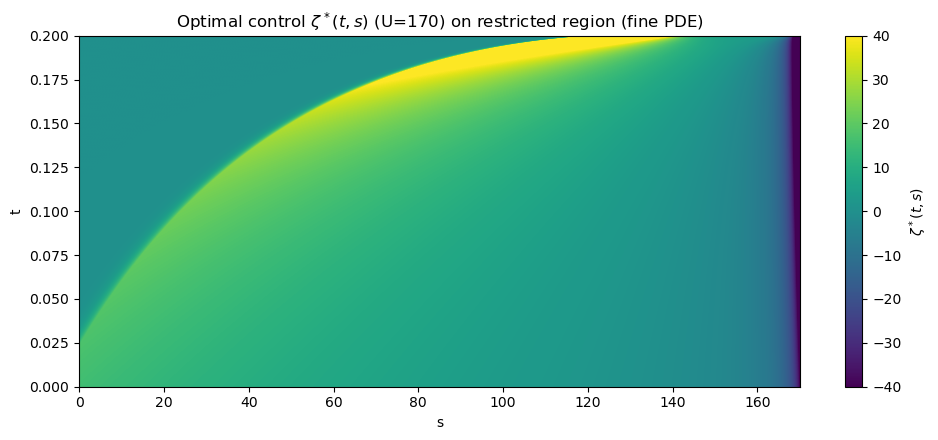

In [14]:
# Plot zeta*
t_max = 0.2
S1_low = 60.0
S_up = U_24
mask_t = (t_grid_u24 <= t_max)
mask_s = (s_grid_u24 >= S_low) & (s_grid_u24 <= S_up)

T_plot = t_grid_u24[mask_t]
S_plot = s_grid_u24[mask_s]
Z_plot = zeta_u24[np.ix_(mask_t, mask_s)]

plt.figure(figsize=(10, 4.5))
plt.imshow(
    Z_plot,
    aspect="auto",
    origin="lower",
    extent=[0, 170, 0, 0.2],
    vmin=-40, vmax=40
)
plt.colorbar(label=r'$\zeta^*(t,s)$')
plt.xlabel("s")
plt.ylabel("t")
plt.title(r'Optimal control $\zeta^*(t,s)$ (U=170) on restricted region (fine PDE)')
plt.tight_layout()
plt.show()

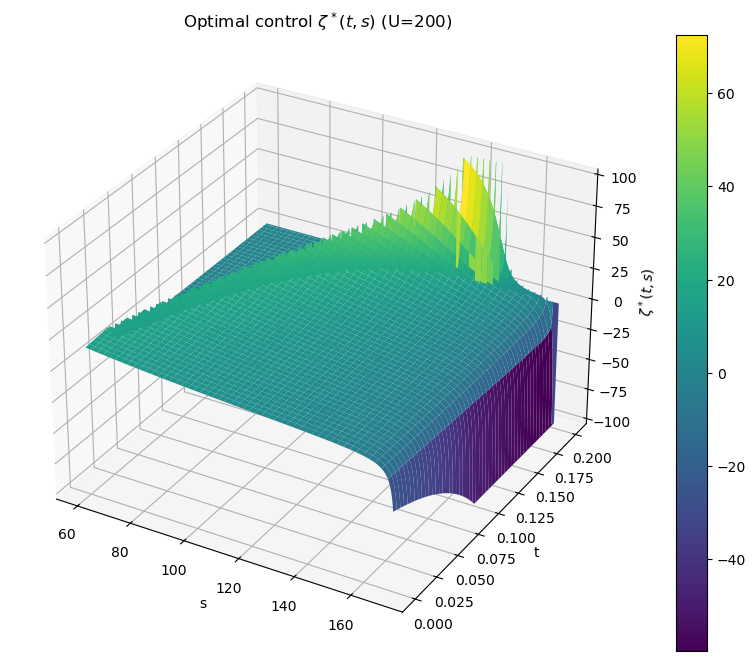

In [15]:
# 3d
ZZ = np.clip(Z_plot, -100.0, 100.0)
TT, SS = np.meshgrid(T_plot, S_plot, indexing="ij")

fig = plt.figure(figsize=(13, 8))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(SS, TT, ZZ, cmap="viridis")

ax.set_xlabel("s")
ax.set_ylabel("t")
ax.set_zlabel(r"$\zeta^*(t,s)$")
ax.set_title(r"Optimal control $\zeta^*(t,s)$ (U=200)")

fig.colorbar(surf)
plt.show()

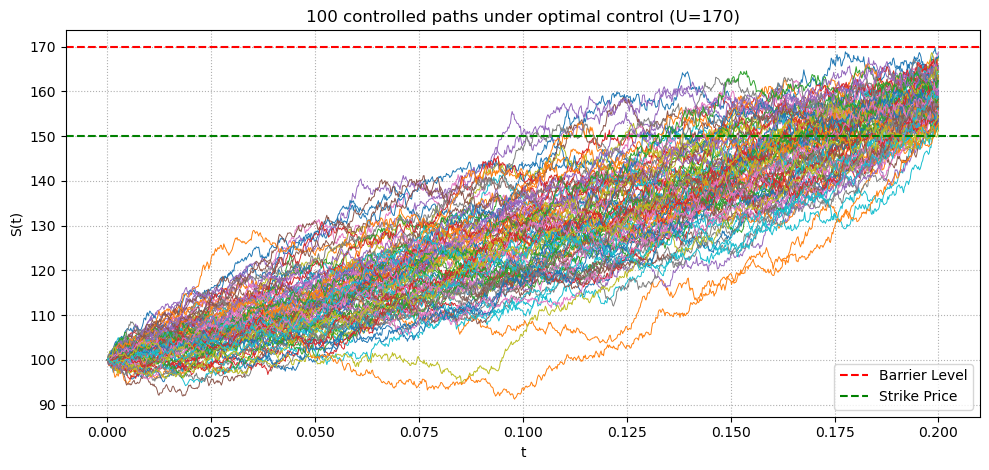

In [16]:
# 100 controlled paths
stats_100_24, paths_100_24 = simulate_controlled_gbm_is_up_and_out(
    S0=S0_24, K=K_24, r=r_24, sigma=sigma_24, T=T_24, U=U_24,
    M=1000, N=100, zeta_eval=zeta_eval_u24)

t_path = np.linspace(0.0, T_24, 1001)

plt.figure(figsize=(10, 4.8))
for i in range(paths_100_24.shape[0]):
    plt.plot(t_path, paths_100_24[i], linewidth=0.7)

plt.axhline(U_24, color='red', linestyle='--', label='Barrier Level')
plt.axhline(K_24, color='green', linestyle='--', label='Strike Price')
plt.xlabel("t")
plt.ylabel("S(t)")
plt.title("100 controlled paths under optimal control (U=170)")
plt.legend()
plt.grid(True, linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()

N=10 , Z_hat=0.007458 , StdErr=0.000828 , sigma=0.002618 , 95% CI Lower=0.005835 , 95% CI Upper=0.009080 , CI len=0.003245 , Over Strike=10 , Barrier Hits=0
N=16 , Z_hat=0.008617 , StdErr=0.000460 , sigma=0.001840 , 95% CI Lower=0.007715 , 95% CI Upper=0.009519 , CI len=0.001804 , Over Strike=16 , Barrier Hits=0
N=26 , Z_hat=0.007483 , StdErr=0.000200 , sigma=0.001020 , 95% CI Lower=0.007091 , 95% CI Upper=0.007875 , CI len=0.000784 , Over Strike=26 , Barrier Hits=0
N=42 , Z_hat=0.007728 , StdErr=0.000273 , sigma=0.001767 , 95% CI Lower=0.007194 , 95% CI Upper=0.008263 , CI len=0.001069 , Over Strike=42 , Barrier Hits=0
N=69 , Z_hat=0.007442 , StdErr=0.000233 , sigma=0.001937 , 95% CI Lower=0.006985 , 95% CI Upper=0.007899 , CI len=0.000914 , Over Strike=69 , Barrier Hits=0
N=100 , Z_hat=0.007606 , StdErr=0.000120 , sigma=0.001204 , 95% CI Lower=0.007370 , 95% CI Upper=0.007842 , CI len=0.000472 , Over Strike=100 , Barrier Hits=0
N=112 , Z_hat=0.007569 , StdErr=0.000145 , sigma=0.00153

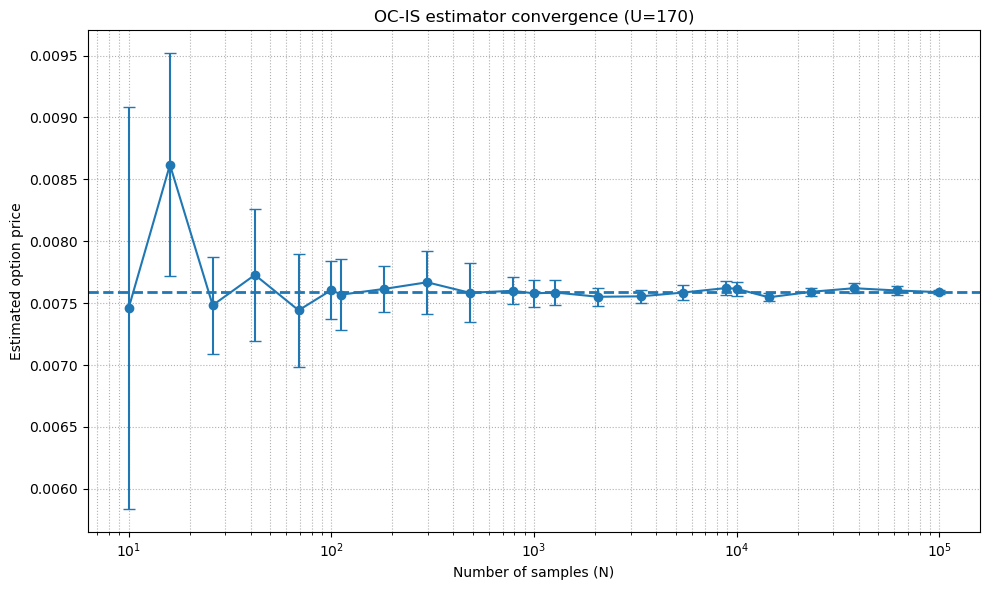

In [18]:
# OC-IS price for several samples
# N_list = [10, 100, 1_000, 10_000, 100_000]
oc_estimates_24 = []
oc_stderr_24 = []

n_range = np.logspace(1, 5, num=20, dtype=int)
n_range = np.append(n_range, [100,1000,10000])
n_range = sorted(np.unique(n_range))
N_list = n_range

for N in N_list:
    statsN, paths = simulate_controlled_gbm_is_up_and_out(
        S0=S0_24, K=K_24, r=r_24, sigma=sigma_24, T=T_24, U=U_24,
        M=1000, N=N, zeta_eval=zeta_eval_u24)
    
    Z_hat = statsN["Z_hat"]
    stderr = statsN["std_err"]
    sigma_hat = stderr * np.sqrt(N)
    # CI
    ci_low = Z_hat - 1.96*stderr
    ci_up = Z_hat + 1.96*stderr
    ci_len = ci_up - ci_low
    
    # Counting over strike qnd hitting barrier
    S_T = paths[:, -1]
    S_max = paths.max(axis=1)
    overK = int(np.sum(S_T>K_24)) #nb over the strike
    KO = int(np.sum(S_max>U_24)) #nb hitting the barrier

    # Print the values
    print(
        f"N={N} , "
        f"Z_hat={Z_hat:.6f} , "
        f"StdErr={stderr:.6f} , "
        f"sigma={sigma_hat:.6f} , "
        f"95% CI Lower={ci_low:.6f} , "
        f"95% CI Upper={ci_up:.6f} , "
        f"CI len={ci_len:.6f} , "
        f"Over Strike={overK} , "
        f"Barrier Hits={KO}")

    # Storing
    oc_estimates_24.append(Z_hat)
    oc_stderr_24.append(stderr)

oc_estimates_24 = np.array(oc_estimates_24)
oc_stderr_24   = np.array(oc_stderr_24)
N_arr = np.array(N_list)

oc_lower_24 = oc_estimates_24 - 1.96*oc_stderr_24
oc_upper_24 = oc_estimates_24 + 1.96*oc_stderr_24
yerr_24 = np.vstack([oc_estimates_24-oc_lower_24, oc_upper_24-oc_estimates_24])

v0_row = V_u24[0, :]
target_price = np.interp(S0_24, s_grid_u24, v0_row)

plt.figure(figsize=(10, 6))
plt.errorbar(N_arr, oc_estimates_24, yerr=yerr_24, fmt="o-", capsize=4)
plt.axhline(target_price, linestyle="--", linewidth=2, label=f"PDE target: {target_price:.6f}")
plt.xscale("log")
plt.xlabel("Number of samples (N)")
plt.ylabel("Estimated option price")
plt.title("OC-IS estimator convergence (U=170)")
plt.grid(True, which="both", linestyle=":", linewidth=0.8)
plt.tight_layout()
plt.show()